name: lcms_data_processing
date: 09/25/2024
version: 1.1
author: Justin Sankey, Johanna Ganglbauer

description: Takes raw liquit chromatography mass spectroscopy (LCMS) data, computes recovery rates, MDL, channel .

When you execute the notebook for the first time you need to install all required python packages.
So, type the following commands in your python console or anaconda prompt:
- pip install pandas
- pip install numpy
- pip install matplotlib
- pip install seaborn
- pip install scikit-learn
- pip install jinja2

In [1]:
# import all needed packages
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from openpyxl import load_workbook
from openpyxl.drawing.image import Image
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

This is the only cell that you should have to make edits to. \
Enter in your desired input and output file paths and change what you deem to be an acceptable recovery range.\
Indicate which samples you want to use to calculate MDL values. You can only use terms which are used in the "Sample Comment" column of your input data.


In [2]:
# raw data upload file path
raw_filepath = r'example_data_raw\20240920_PFAS_Standard_Check_Updated.txt'
# raw_filepath = r'example_data_raw\20230703_ACF_Batch1_update_20240923.txt'

# processed data output excel file path
processed_filepath =r'example_data_processed\single_compound.xlsx'
# processed_filepath =r'example_data_processed\PFAS_ACF_Batch1.xlsx'

# processed data long format
processed_filepath_long =r'example_data_processed\single_compound.csv'
# processed_filepath_long =r'example_data_processed\PFAS_ACF_Batch1.csv'

# directory to save plots to
plot_directory = r'example_figures'
  
# file paths for IDL and IQL data - not meant to be adopted
IDL_2024_filepath = r'example_data_raw\IDL_2024.csv'
IDL_IQL_filepath = r'example_data_raw\IDL_IQL.csv'

#color-coding for recoveries table
in_range = 'background-color: green'
in_range_min_val = 0.6 
in_range_max_val = 1.4
out_range = 'background-color: red'
out_range_min_val = 0.4 
out_range_max_val = 1.8
question_range = 'background-color: yellow'

# samples used for MDL calculatation - keywords need to be used in "Sample Comment" column of input data
# if you want to use IDLs only, use an empty list.
mdl_selection = [
    'stupid', # 'IS Check', 'Process Blank', 'Water Extraction Blank'
]

#Ensure file path and folder path exist to write outputs to
folder_path = os.path.dirname(processed_filepath)
if folder_path and not os.path.exists(folder_path):
    os.makedirs(folder_path) 
    
folder_path = os.path.dirname(processed_filepath_long)
if folder_path and not os.path.exists(folder_path):
    os.makedirs(folder_path) 
# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)  # Create folder if it doesn't exist
# if not os.path.exists(processed_filepath):
#     with open(processed_filepath, 'w') as f:
#         pass  # Creates an empty file
    
# folder_path = os.path.dirname(processed_filepath_long)
# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)  # Create folder if it doesn't exist
# if not os.path.exists(processed_filepath_long):
#     with open(processed_filepath_long, 'w') as f:
#         pass  # Creates an empty file
    
if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)  # Create folder if it doesn't exist


In [3]:
# Load data file
if raw_filepath[-4:] == '.csv':
    data = pd.read_csv(raw_filepath, delimiter=',', encoding='utf-8', low_memory=False, header=0,)
elif raw_filepath[-4:] == '.txt':
    data = pd.read_csv(raw_filepath, delimiter='\t', encoding='utf-8', low_memory=False, header=0,)

# clean up messy 'calculated concentration' column
data['Calculated Concentration'] = data['Calculated Concentration'].replace(
    {'<1 points': np.nan, '< 0': np.nan, 'no root': np.nan, 'NaN': np.nan}
    ).astype('float')

# Replace 'IPS-13C2_PFOA' values
data['Component Group Name'] = data['Component Group Name'].replace('IPS-13C2_PFOA', 'IPS-13C4_PFOA')

# Find rows where 'Component Group Name' is 'IPS-13C4_PFOA' (after replacement)
mask = data['Component Group Name'] == 'IPS-13C4_PFOA'

# Iterate through each of these rows
for idx, row in data[mask].iterrows():
    sample_name = row['Sample Name']
    
    # Find the corresponding row with 'Component Name' == 'IPS-13C4_PFOA' and the same 'Sample Name'
    matching_row = data[(data['Component Name'] == 'IPS-13C4_PFOA') & (data['Sample Name'] == sample_name)]
    
    if not matching_row.empty:
        # Update the 'Area IPS' with the value from 'Area' in the matching row
        data.at[idx, 'Area IPS'] = matching_row['Area'].values[0]
# correct channel names in original data (all of the TOF channels are labelled by _TOF MS, only 2 of them are labeled by only _TOF)
mask_names = data['Component Name'].str.endswith('_TOF')
data['Component Name'][mask_names] = [compound + ' MS' for compound in data['Component Name'][mask_names].to_list()]

# split data into quantification data, calibration data, and process blanks
calibration_only = data[(data['Sample Type'] == 'Standard')]
quantification_blank = data[(data['Sample Type'] != 'Standard')]

if mdl_selection == []:
    blank_only = None
    quantification_only = quantification_blank
else:
    blank_selection = quantification_blank['Sample Comment'].str.contains('|'.join(mdl_selection))
    if sum(blank_selection) == 0:
        print(f'Be careful, no samples have been collected for the MDL calculation because {mdl_selection} is not a Sample Comment.')
        print(f'If you do not select blank set variable mdl_selection to [].')
    if sum(blank_selection) == len(quantification_blank):
        print(f'Be careful, all samples have been collected for the MDL calculation.')
        print(f'If this is not what you want reset the variable mdl_selection in the top block.')
    blank_selection.replace({np.nan: False}, inplace=True)
    blank_only = quantification_blank[blank_selection]
    quantification_only = quantification_blank[~blank_selection]

# display settings 
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full width of columns


Be careful, no samples have been collected for the MDL calculation because ['stupid'] is not a Sample Comment.
If you do not select blank set variable mdl_selection to [].


C:\Users\jhsan\anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Calculate response factors from calibration data: ratio of (i) calculated area of IDA (=extracted standard) * actual concentration of IPS and (ii) calculated area of IPS (=non extracted standard) * actual concentration of IDA
Generate boxplot of response factors and write mean as well as standard deviation for each IDA to csv.

Conclusio: used values are very close to new calculation - maybe one or two calibration points missing or added - not a big problem. \n
Response factor varies tremendously from PFAS to PFAS, I would not use average of all response factors. \n
Right now concentration is used for normalization only for IPS - discuss with Jitka and Simon why IDA concentration is not included in evaluation.

In [4]:
# define funtion which calculates the IDA IPS ratio.
# challenge - search right IPS row indicated in the Component Group Name of IDA.
def calulate_ida_ips_ratio(data: pd.DataFrame, column_name:str, filename: str) -> pd.DataFrame:    
    """Calculates IDA area times IDA concentration divided by IPS area times IPS concentration.

    :param data: Entire data junk (including all rows and the following columns:
    Component Name, Sample Index, Component Group Name, Actual Concentration, Area, and IDA Average Response Factor
    :type data: pd.DataFrame
    :param column_name: name of column, the calculated ratio should be saved to
    :type column_name: str
    :param filename: filename of raw data, needed to distinguish between samples
    :type filename: str
    :return: Data junk only containing IDA rows with the corresponding ratio saved to new column
    :rtype: pd.DataFrame
    """ 
    data_only_ida = data[data['Component Name'].str.contains('IDA')] 
    data_only_ida.loc[:,f'{column_name}'] = [np.nan] * len(data_only_ida)
    data_only_ida.loc[:,'IPS Area'] = [np.nan] * len(data_only_ida)
    data_only_ida.loc[:,'IPS Concentration'] = [np.nan] * len(data_only_ida)
    for row_index in data_only_ida.index:
        sample_index = data_only_ida.loc[row_index, 'Sample Index']
        ips_channel_name = data_only_ida.loc[row_index, 'Component Group Name']
        # catch unlinked labeling
        if ips_channel_name == 'IPS-13C2_PFOA' and filename.split('\\')[1][:6] == '202409':
            print('attention, IPS-13C2_PFOA needs relabeling')
            ida_channel_name = data_only_ida.loc[row_index,'Component Name']
            if ida_channel_name == 'IDA-13C5_PFHxA':
                ips_channel_name = 'IPS-13C2_PFHxA'
            elif ida_channel_name == 'IDA-13C9_PFNA':
                ips_channel_name = 'IPS-13C5_PFNA'
            elif ida_channel_name == 'IDA-13C6_PFDA':
                ips_channel_name = 'IPS-13C2_PFDA'
            else:
                ips_channel_name = 'IPS-13C4_PFOA'
        corresponding_ips_area_row = data[(
            (data['Sample Index'] == sample_index) &
            (data['Component Name'] == ips_channel_name)
            )]
        data_only_ida.loc[row_index, 'IPS Area'] = corresponding_ips_area_row['Area'].iloc[0]
        data_only_ida.loc[row_index, 'IPS Concentration'] = corresponding_ips_area_row['Actual Concentration'].iloc[0]
        data_only_ida.loc[row_index, f'{column_name}'] = \
            (data_only_ida.loc[row_index, 'Area'] * corresponding_ips_area_row['Actual Concentration']).iloc[0] \
            / (corresponding_ips_area_row['Area'] * data_only_ida.loc[row_index, 'Actual Concentration']).iloc[0]
    
    return data_only_ida

C:\Users\jhsan\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\jhsan\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


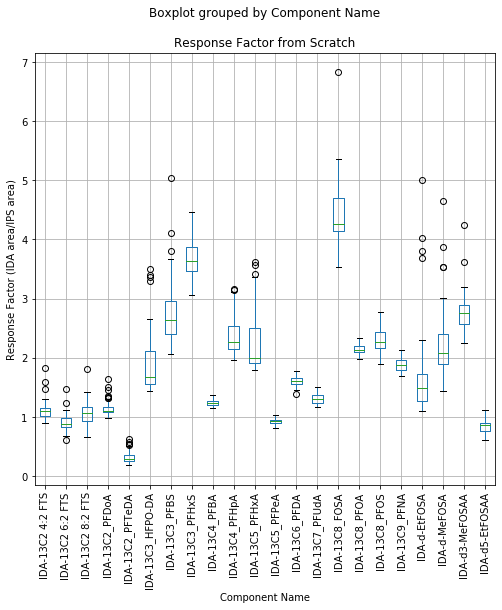

In [5]:
# extract values of IDAs (= extracted standard) and IPS (=non extracted standard)
# and save basic sample information as well as areas of intensity peak, actual concentration and Component Group Name.
# the component group name is useful to assoiciate the right IPS to each IDA.
selected_columns = ['Sample Name', 'Sample Index','Component Name', 'Component Group Name', 'Area', 'Actual Concentration', 'IDA Average Response Factor']
calibration_only_ida = calibration_only[selected_columns]

# calucluate IDA IPS ratio to compute response factors with calibration data
calibration_only_ida = calulate_ida_ips_ratio(
    data=calibration_only_ida, column_name='Response Factor from Scratch', filename=raw_filepath,
    )

# create and save response factor box plots
image_path = os.path.join(plot_directory, 'response_factors.png')
_, ax = plt.subplots(figsize=(8, 8))
calibration_only_ida.boxplot(column='Response Factor from Scratch', by='Component Name', ax=ax)
plt.ylabel('Response Factor (IDA area/IPS area)')
plt.xticks(rotation=90)
plt.savefig(image_path)
plt.show()

# place holder to compare response factors with original data
calibration_only_ida['Response Factor from Scratch'] = calibration_only_ida['Response Factor from Scratch'] / 1

# create data frame with this response factor calculation (from scratch), the standard deviation and the original values evaluated by Sciex,
response_factor = calibration_only_ida.groupby('Component Name', as_index=False)['Response Factor from Scratch'].mean()
response_factor['Response Factor Std'] = calibration_only_ida.groupby('Component Name')['Response Factor from Scratch'].std().to_list()
response_factor['Response Factor Sciex'] = calibration_only_ida.groupby('Component Name')['IDA Average Response Factor'].mean().to_list()
response_factor.rename(columns={'Response Factor from Scratch': 'Response Factor Mean'}, inplace=True)
response_factor.index = response_factor['Component Name']
response_factor.drop(columns=['Component Name'], inplace=True)

# write response factor to excel file
with pd.ExcelWriter(processed_filepath, engine='openpyxl') as writer:
    response_factor.to_excel(writer, sheet_name='Response Factor')

# save recoveries image to excel file
workbook = load_workbook(processed_filepath)
plot_sheet = workbook.create_sheet('Details RF')

img = Image(os.path.join(plot_directory, 'response_factors.png'))

cell_position = plot_sheet.cell(row=1, column=1).coordinate
plot_sheet.add_image(img, cell_position)

workbook.save(processed_filepath)

Calculate recovery rate for each IDA compound in each sample.
$$
recovery~rate = \frac{\frac{area_{IDA~sample}~\cdot~concentration_{IPS~sample}}{area_{IPS~sample}~\cdot~concentration_{IDA~sample}}}{average(\frac{area_{IDA~calibration}~\cdot~concentration_{IPS~calibration}}{(area_{IPS~calibration}~\cdot~concentration_{IDA~calibration})})} = \frac{ratio}{response~factor}
$$
Indicate uncertainty by maximum error method.
$$
\Delta recovery~rate = \Delta response~factor * \frac{ratio}{response~factor^{2}} + \Delta ratio * \frac{1}{response~factor}
$$

Assign right recovery rate with uncertainty to each PFAS default channel.
The assignment works for each sample by using the 'IS Name' column which provides information on which IDA standard is associated to which PFAS.

In [6]:
# select ida rows from quantification data and calculate ida ips ratio
selected_columns = [
    'Sample Name', 'Sample Index', 'Component Name', 'Component Group Name', 'Area', 'Actual Concentration', 'Reported Recovery'
    ]
quantification_ida = quantification_only[selected_columns]
quantification_ida = calulate_ida_ips_ratio(
    data=quantification_ida, column_name="IDA-IPS Ratio", filename=raw_filepath,
    )

# assign right response factor to each IDA and calculate Recovery rate
quantification_ida.loc[:, 'Response Factor Mean'] = [np.nan] * len(quantification_ida)
quantification_ida.loc[:, 'Response Factor Std'] = [np.nan] * len(quantification_ida)

for component in response_factor.index:
    quantification_ida.loc[quantification_ida['Component Name'] == component, 'Response Factor Mean'] = response_factor.loc[component, 'Response Factor Mean']
    quantification_ida.loc[quantification_ida['Component Name'] == component, 'Response Factor Std'] = response_factor.loc[component, 'Response Factor Std']

# calculate recovery rate and its related uncertainty
quantification_ida['Recovery Rate'] = quantification_ida['IDA-IPS Ratio'] / quantification_ida['Response Factor Mean']
quantification_ida['Recovery Rate Uncertainty 1'] = quantification_ida['Response Factor Std'] * quantification_ida['IDA-IPS Ratio'] \
     / (quantification_ida['Response Factor Mean'] * quantification_ida['Response Factor Mean'])

# assign right recovery rate to each natural pfas channel
selected_columns = [
    'Sample Name', 'Sample Index', 'Acquisition Date & Time', 'Component Name', 'IS Name', 'Calculated Concentration', 'Area',
    ]
quantification_pfas_default = quantification_only[selected_columns]
quantification_pfas_default.rename(columns={'IS Name': 'IDA Name'}, inplace=True)

# get only PFAS default channels
quantification_pfas_default = quantification_pfas_default[~quantification_pfas_default['Component Name'].str.contains('IDA|IPS|13C|MS')]

# assign right recovery rate and uncertainty to each PFAS compound
quantification_pfas_default.loc[:,'IDA Area'] = [np.nan] * len(quantification_pfas_default)
quantification_pfas_default.loc[:,'IDA Concentration'] = [np.nan] * len(quantification_pfas_default)
quantification_pfas_default.loc[:,'IPS Area'] = [np.nan] * len(quantification_pfas_default)
quantification_pfas_default.loc[:,'IPS Concentration'] = [np.nan] * len(quantification_pfas_default)
quantification_pfas_default.loc[:,'IDA-IPS Ratio'] = [np.nan] * len(quantification_pfas_default)
quantification_pfas_default.loc[:,'IPS Name'] = [np.nan] * len(quantification_pfas_default)
quantification_pfas_default.loc[:,'Recovery Rate'] = [np.nan] * len(quantification_pfas_default)
quantification_pfas_default.loc[:,'Recovery Rate Uncertainty 1'] = [np.nan] * len(quantification_pfas_default)
quantification_pfas_default.loc[:,'Recovery Rate Sciex'] = [np.nan] * len(quantification_pfas_default)
for row_index in quantification_pfas_default.index:
    sample_index = quantification_pfas_default.loc[row_index, 'Sample Index']
    ida_channel_name = quantification_pfas_default.loc[row_index, 'IDA Name']
    recovery_row = quantification_ida[(
        (quantification_ida['Component Name'] == ida_channel_name) &
        (quantification_ida['Sample Index'] == sample_index)
    )]
    quantification_pfas_default.loc[row_index,'IDA Area'] = recovery_row.loc[:,'Area'].to_list()[0]
    quantification_pfas_default.loc[row_index,'IDA Concentration'] = recovery_row.loc[:,'Actual Concentration'].to_list()[0]
    quantification_pfas_default.loc[row_index,'IPS Area'] = recovery_row.loc[:,'IPS Area'].to_list()[0]
    quantification_pfas_default.loc[row_index,'IPS Concentration'] = recovery_row.loc[:,'IPS Concentration'].to_list()[0]
    quantification_pfas_default.loc[row_index, 'IDA-IPS Ratio'] = \
        (recovery_row.loc[:,'IDA-IPS Ratio'] * 100).to_list()[0]
    quantification_pfas_default.loc[row_index, 'IPS Name'] = \
        recovery_row.loc[:,'Component Group Name'].to_list()[0]
    quantification_pfas_default.loc[row_index, 'Recovery Rate'] = \
        (recovery_row.loc[:,'Recovery Rate'] * 100).to_list()[0]
    quantification_pfas_default.loc[row_index, 'Recovery Rate Uncertainty 1'] = \
        (recovery_row.loc[:,'Recovery Rate Uncertainty 1'].round(decimals=3) * 100).to_list()[0]
    quantification_pfas_default.loc[row_index, 'Recovery Rate Sciex'] = \
        recovery_row.loc[:,'Reported Recovery'].to_list()[0]
    
    for column in ['IDA-IPS Ratio', 'Recovery Rate', 'Recovery Rate Uncertainty 1', 'Recovery Rate Sciex']:
        quantification_pfas_default[f'{column}'] = quantification_pfas_default[f'{column}'].round(decimals=1)

# put relevant information to pivot tables
ratio_ida_ips = quantification_pfas_default.pivot_table(
    index=('Sample Name',), columns='Component Name', values='IDA-IPS Ratio', aggfunc='first'
    )
recovery_sciex = quantification_pfas_default.pivot_table(
    index=('Sample Name',), columns='Component Name', values='Recovery Rate Sciex', aggfunc='first'
    )
recovery = quantification_pfas_default.pivot_table(
    index=('Sample Name',), columns='Component Name', values='Recovery Rate', aggfunc='first'
    )
recovery_uncertainty_1 = quantification_pfas_default.pivot_table(
    index=('Sample Name',), columns='Component Name', values='Recovery Rate Uncertainty 1', aggfunc='first'
    )

# write to excel file
with pd.ExcelWriter(processed_filepath, engine='openpyxl', mode='a') as writer:
    recovery_sciex.to_excel(writer, sheet_name='Recovery Rate Sciex')
    recovery.to_excel(writer, sheet_name='Recovery Rate')
    recovery_uncertainty_1.to_excel(writer, sheet_name='Recovery Rate Uncertainty 1')
    ratio_ida_ips.to_excel(writer, sheet_name='IDA-IPS Ratio')

C:\Users\jhsan\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\jhsan\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\jhsan\anaconda3\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Calculation of sample ida - ips ratio and calibration ida - ips ratio (refered to as response factor above) - Method Justin:
Uses columns "IDA area" and "IPS area" directly


In [7]:
#Area IDA values for IDA components
selected_columns_area = ['Sample Name', 'Sample Index','Acquisition Date & Time','Component Name', 'Area IDA']
area_ida = quantification_blank[selected_columns_area]
area_ida = area_ida[area_ida['Component Name'].str.contains('IDA')]
area_ida.loc[:,'Sample Name Date'] = area_ida['Sample Name'].astype(str) + "_" + area_ida['Acquisition Date & Time']

# Create pivot table with Sample name as the index, component name as the column headers, and area as the values
area_ida_piv = area_ida.pivot_table(index=('Sample Name Date',), columns='Component Name', values='Area IDA', aggfunc='first')
area_ida_piv

Component Name,IDA-13C2 4:2 FTS,IDA-13C2 6:2 FTS,IDA-13C2 8:2 FTS,IDA-13C2_PFDoA,IDA-13C2_PFTeDA,IDA-13C3_HFPO-DA,IDA-13C3_PFBS,IDA-13C3_PFHxS,IDA-13C4_PFBA,IDA-13C4_PFHpA,IDA-13C5_PFHxA,IDA-13C5_PFPeA,IDA-13C6_PFDA,IDA-13C7_PFUdA,IDA-13C8_FOSA,IDA-13C8_PFOA,IDA-13C8_PFOS,IDA-13C9_PFNA,IDA-d-EtFOSA,IDA-d-MeFOSA,IDA-d3-MeFOSAA,IDA-d5-EtFOSAA
Sample Name Date,,,,,,,,,,,,,,,,,,,,,,
PFAS QCS0 0ng/ml_09/17/2024 15:14:43,8991.469622,6972.744215,14417.672473,75926.752064,12371.844182,94077.208338,28995.893463,43876.262496,65593.887435,134525.158523,112709.156275,50932.289284,118617.156309,86833.658764,52111.919285,127520.687210,25633.854307,107988.099802,4662.714736,5853.663720,38525.215949,12307.829398
PFAS QCS0 0ng/ml_09/18/2024 15:10:07,9056.247533,7140.944832,12507.012024,46688.031672,11380.007453,79234.480853,27297.629595,38769.791542,67295.732321,117855.148107,93375.540572,47865.954176,84069.707102,65184.603044,43790.863808,103109.228381,23334.375150,102401.224820,8790.793201,12664.660069,33547.081009,11542.715181
PFBA_72hr_Dup_09/18/2024 13:11:46,24191.369559,31297.425076,60348.896666,179922.317079,41948.421173,256411.445167,74504.813310,116505.441503,184192.494616,389012.932463,291676.710237,131449.690797,294167.060374,197064.843513,130171.848603,342107.590349,66000.948873,301085.287496,57677.020265,54933.946501,123371.149636,35031.772380
PFBS_72hr_Dup_09/18/2024 13:45:46,23986.867342,20576.047877,39346.431245,192663.230372,47686.111922,263525.515201,73383.953142,110404.279600,190291.265126,359533.275753,289804.388107,131629.057250,316387.700682,233907.430522,139225.838234,332974.662029,65050.876266,292383.644571,63059.791502,58161.257854,114722.497200,36322.492551
PFOA_72hr_09/18/2024 13:28:22,24118.631137,20060.737159,47085.955576,185584.642154,49613.684451,250443.554604,76285.326206,113302.290349,191398.609057,359349.392854,283354.802581,133431.028252,294659.801718,236398.524533,139807.341770,315741.954828,62726.831223,274173.018960,60388.892817,56400.611223,125758.832626,37017.086920
PFOS_72hr_Dup_09/18/2024 14:02:27,26296.028256,21527.441579,37740.225235,203446.251960,47889.583673,253335.041407,75633.689879,117356.652734,193931.965374,373720.709193,305670.179315,136267.204818,289270.139405,223832.735147,139021.787365,333074.494992,66473.669755,289513.291603,63525.864560,61090.479136,111256.789467,34446.820630
Standard_check_327ai_343g_09/18/2024 14:53:30,14058.265090,11875.163460,20097.930873,118684.160623,26993.522517,159272.139301,46052.363955,69629.893977,112485.982827,202798.684458,174805.517197,79816.999656,166658.059519,118431.406844,82933.130233,196439.102205,41670.179063,171896.039529,36730.534629,36820.240865,51507.883814,16996.483136
Standard_check_327aj_343g_09/18/2024 14:19:06,26066.465229,21850.794837,37738.409377,185222.350626,51500.495521,267118.134499,80235.310928,115704.340773,200040.629566,388734.128671,307540.913571,143471.924064,311341.365943,258079.802106,150356.048862,348306.833861,68502.974591,280077.193383,71290.148076,68604.011696,114197.917297,35167.904460
Standard_check_327aj_343o_09/18/2024 14:36:12,25190.957484,21293.133701,34811.715283,186965.281237,52059.563376,263516.568249,76849.150124,119252.741894,190110.862569,355808.816113,304262.362810,138472.416031,247192.842175,222568.412952,141915.053072,337424.243639,68553.174618,292074.741761,64831.075237,62709.057991,111660.188431,32110.778452


In [8]:
#Calibration Area IDA Average for IDA components
selected_columns_area = ['Sample Name', 'Sample Index','Acquisition Date & Time','Component Name', 'Area IDA']
cal_area_ida = calibration_only[selected_columns_area]
cal_area_ida = cal_area_ida[cal_area_ida['Component Name'].str.contains('IDA')]
cal_area_ida.loc[:,'Sample Name Date'] = cal_area_ida['Sample Name'].astype(str) + "_" + cal_area_ida['Acquisition Date & Time']

# Create pivot table with Sample name as the index, component name as the column headers, and area as the values
cal_area_ida_piv = cal_area_ida.pivot_table(index=('Sample Name Date',), columns='Component Name', values='Area IDA', aggfunc='first')
#Establishes a row with average of each column
mean_cal = cal_area_ida_piv.mean(skipna=True)
mean_cal=pd.DataFrame(mean_cal).T
mean_cal.index=['Average']
cal_area_ida_piv = pd.concat([cal_area_ida_piv,mean_cal])

In [9]:
#IPS Area Values for IDA components
selected_columns_area = ['Sample Name', 'Sample Index','Acquisition Date & Time','Component Name', 'Area IPS']
area_ips = quantification_blank[selected_columns_area]
area_ips = area_ips[area_ips['Component Name'].str.contains('IDA')]
area_ips.loc[:,'Sample Name Date'] = area_ips['Sample Name'].astype(str) + "_" + area_ips['Acquisition Date & Time']

# Create pivot table with Sample name as the index, component name as the column headers, and area as the values
area_ips_piv = area_ips.pivot_table(index=('Sample Name Date',), columns='Component Name', values='Area IPS', aggfunc='first')

In [10]:
#IPS Calibration Area and Average for IDA components
selected_columns_area = ['Sample Name', 'Sample Index','Acquisition Date & Time','Component Name', 'Area IPS']
cal_area_ips = calibration_only[selected_columns_area]
cal_area_ips = cal_area_ips[cal_area_ips['Component Name'].str.contains('IDA')]
cal_area_ips.loc[:,'Sample Name Date'] = cal_area_ips['Sample Name'].astype(str) + "_" + cal_area_ida['Acquisition Date & Time']

# Create pivot table with Sample name as the index, component name as the column headers, and area as the values
cal_area_ips_piv = cal_area_ips.pivot_table(index=('Sample Name Date',), columns='Component Name', values='Area IPS', aggfunc='first')
#establishes mean for each column
mean_cal = cal_area_ips_piv.mean(skipna=True)
mean_cal=pd.DataFrame(mean_cal).T
mean_cal.index=['Average']
cal_area_ips_piv = pd.concat([cal_area_ips_piv,mean_cal])


In [11]:
#calibration IDA/IPS ratio
cal_ida_ips_ratio = cal_area_ida_piv.loc['Average']/cal_area_ips_piv.loc['Average']
cal_area_ips_piv.loc['Average']
cal_area_ida_piv.loc['Average']
#Sample IDA/IPS Ratio
sample_ida_ips_ratio = area_ida_piv/area_ips_piv

In [12]:
#IPS normalized recoveries to calibration data
ips_norm_recovery = sample_ida_ips_ratio/cal_ida_ips_ratio
# ips_norm_recovery
# color code recoveries
def color_map(val):
    if in_range_min_val <= val <= in_range_max_val:
        return in_range
    elif val < out_range_min_val or val > out_range_max_val:
        return out_range
    else:
        return question_range

# Apply the style function to the entire DataFrame
styled_ips_norm_recovery = ips_norm_recovery.style.applymap(color_map)
styled_ips_norm_recovery


Component Name,IDA-13C2 4:2 FTS,IDA-13C2 6:2 FTS,IDA-13C2 8:2 FTS,IDA-13C2_PFDoA,IDA-13C2_PFTeDA,IDA-13C3_HFPO-DA,IDA-13C3_PFBS,IDA-13C3_PFHxS,IDA-13C4_PFBA,IDA-13C4_PFHpA,IDA-13C5_PFHxA,IDA-13C5_PFPeA,IDA-13C6_PFDA,IDA-13C7_PFUdA,IDA-13C8_FOSA,IDA-13C8_PFOA,IDA-13C8_PFOS,IDA-13C9_PFNA,IDA-d-EtFOSA,IDA-d-MeFOSA,IDA-d3-MeFOSAA,IDA-d5-EtFOSAA
Sample Name Date,,,,,,,,,,,,,,,,,,,,,,
PFAS QCS0 0ng/ml_09/17/2024 15:14:43,0.690386,0.643610,1.125846,1.217398,0.755402,0.954707,0.910585,1.000791,0.932954,1.050147,0.952782,0.982265,1.308740,1.189439,1.007995,1.058379,0.930540,1.035893,0.246955,0.229416,1.178459,1.197950
PFAS QCS0 0ng/ml_09/18/2024 15:10:07,0.781970,0.741235,1.098293,0.748589,0.694842,0.804081,0.964028,0.994461,1.026260,0.920016,0.789346,0.989772,0.927567,0.892892,0.952545,0.855772,0.952572,0.982300,0.523586,0.558175,1.153998,1.263414
PFBA_72hr_Dup_09/18/2024 13:11:46,0.905899,1.408920,2.298326,1.215860,1.079492,1.096690,1.141107,1.296040,1.082073,1.279886,1.039194,1.047087,1.367919,1.137689,1.227996,1.196695,1.168502,1.217276,1.489843,1.050015,1.840524,1.662944
PFBS_72hr_Dup_09/18/2024 13:45:46,1.471247,1.517162,2.454371,2.562937,2.415664,2.218757,1.840923,2.011641,1.992153,2.328558,2.032546,1.868505,2.896187,2.658271,2.151256,2.292835,1.886362,2.326983,2.667981,1.820878,2.803295,2.824123
PFOA_72hr_09/18/2024 13:28:22,0.657941,0.657869,1.306317,1.092148,1.111851,0.932819,0.851134,0.918175,0.948478,1.029592,0.879157,0.896570,1.193241,1.188503,0.960781,0.961821,0.808998,0.965307,1.136343,0.785332,1.366725,1.280066
PFOS_72hr_Dup_09/18/2024 14:02:27,1.604744,1.579306,2.342302,2.729825,2.446988,2.151436,1.887789,2.127531,2.068129,2.441413,2.162393,1.970418,2.670894,2.565812,2.137267,2.313391,1.917896,2.324100,2.674142,1.902936,2.704895,2.664776
Standard_check_327ai_343g_09/18/2024 14:53:30,0.488223,0.495774,0.709840,0.954795,0.826957,0.810971,0.654125,0.718347,0.729651,0.794313,0.741428,0.702022,0.922596,0.813955,0.725562,0.818028,0.684182,0.827341,0.879896,0.652691,0.712637,0.748240
Standard_check_327aj_343g_09/18/2024 14:19:06,0.739953,0.745671,1.089503,1.021235,1.081307,0.932145,0.931559,0.975718,0.947513,1.043503,0.893987,0.921452,1.181236,1.215632,1.075235,0.994069,0.919372,0.923870,1.395950,0.994046,1.291483,1.265507
Standard_check_327aj_343o_09/18/2024 14:36:12,1.412836,1.435638,1.985617,2.457768,2.606070,2.192481,1.762824,1.986864,1.902350,2.277223,2.108747,1.878821,2.236061,2.499537,2.005100,2.296036,1.817752,2.297074,2.508122,1.795199,2.494904,2.282938


In [13]:
# Reset the index to turn 'Sample Name Date' into a column
calculated_recovery = ips_norm_recovery.reset_index()

pattern = r'(.+?)_(\d{2}/\d{2}/\d{4} \d{2}:\d{2}:\d{2})'

# Apply the regex to extract 'Sample Name' and 'Acquisition Date & Time'
calculated_recovery[['Sample Name', 'Acquisition Date & Time']] = calculated_recovery['Sample Name Date'].str.extract(pattern)

# Convert 'Acquisition Date & Time' to datetime format
calculated_recovery['Acquisition Date & Time'] = pd.to_datetime(calculated_recovery['Acquisition Date & Time'], format='%m/%d/%Y %H:%M:%S', errors='coerce')
calculated_recovery['Acquisition Date & Time'] = calculated_recovery['Acquisition Date & Time'].dt.strftime('%m/%d/%Y %H:%M:%S')

# Drop the original 'Sample Name Date' if no longer needed
calculated_recovery.drop('Sample Name Date', axis=1, inplace=True)
calculated_recovery= pd.melt(calculated_recovery, 
                      id_vars=['Sample Name', 'Acquisition Date & Time'],  # Keep these as identifier variables
                      var_name='IDA Name',    # The new column for 'IDA name' will contain what were previously column names
                      value_name='Calculated Recovery')     # This column will contain the values from the old 'IDA name' columns

# Perform an inner merge to get only the rows that match on 'Sample Name', 'Acquisition Date & Time', and 'IDA Name'
matching_rows_df = pd.merge(
    quantification_pfas_default[['Sample Name', 'Acquisition Date & Time', 'IDA Name']],
    calculated_recovery[['Sample Name', 'Acquisition Date & Time', 'IDA Name']],
    on=['Sample Name', 'Acquisition Date & Time', 'IDA Name'],
    how='inner'
)

# Filter quantification_pfas_default for rows that match in all three columns
quantification_matching = quantification_pfas_default[
    quantification_pfas_default[['Sample Name', 'Acquisition Date & Time', 'IDA Name']].apply(
        tuple, axis=1
    ).isin(matching_rows_df.apply(tuple, axis=1))
]

# Filter calculated_recovery for rows that match in all three columns
calculated_recovery_matching = calculated_recovery[
    calculated_recovery[['Sample Name', 'Acquisition Date & Time', 'IDA Name']].apply(
        tuple, axis=1
    ).isin(matching_rows_df.apply(tuple, axis=1))
]
# Merge the filtered calculated_recovery back into quantification_pfas_default
quantification_pfas_default = quantification_pfas_default.merge(
    calculated_recovery_matching[['Sample Name', 'Acquisition Date & Time', 'IDA Name', 'Calculated Recovery']],
    on=['Sample Name', 'Acquisition Date & Time', 'IDA Name'],
    how='left'  # Using 'left' join to keep all rows from quantification_pfas_default
)
# Add a new column 'Poor Recovery' based on whether 'Calculated Recovery' is outside the range
quantification_pfas_default.loc[:,'Poor Recovery'] = ~quantification_pfas_default['Calculated Recovery'].between(out_range_min_val, out_range_max_val, inclusive='both')


In [14]:
#Reported Recovery Pivot Table
selected_columns_area = ['Sample Name', 'Sample Index','Acquisition Date & Time','Component Name', 'Reported Recovery']
reported_recovery = quantification_blank[selected_columns_area]
reported_recovery = reported_recovery[reported_recovery['Component Name'].str.contains('IDA')]
reported_recovery.loc[:,'Sample Name Date'] = reported_recovery['Sample Name'].astype(str) + "_" + reported_recovery['Acquisition Date & Time']

# Create pivot table with Sample name as the index, component name as the column headers, and area as the values
reported_recovery_piv = reported_recovery.pivot_table(index=('Sample Name Date',), columns='Component Name', values='Reported Recovery', aggfunc='first')
reported_recovery_piv=reported_recovery_piv/100

In [15]:
#Color map of Reported recoveries
styled_reported_recovery = reported_recovery_piv.style.applymap(color_map)
styled_reported_recovery

Component Name,IDA-13C2 4:2 FTS,IDA-13C2 6:2 FTS,IDA-13C2 8:2 FTS,IDA-13C2_PFDoA,IDA-13C2_PFTeDA,IDA-13C3_HFPO-DA,IDA-13C3_PFBS,IDA-13C3_PFHxS,IDA-13C4_PFBA,IDA-13C4_PFHpA,IDA-13C5_PFHxA,IDA-13C5_PFPeA,IDA-13C6_PFDA,IDA-13C7_PFUdA,IDA-13C8_FOSA,IDA-13C8_PFOA,IDA-13C8_PFOS,IDA-13C9_PFNA,IDA-d-EtFOSA,IDA-d-MeFOSA,IDA-d3-MeFOSAA,IDA-d5-EtFOSAA
Sample Name Date,,,,,,,,,,,,,,,,,,,,,,
PFAS QCS0 0ng/ml_09/17/2024 15:14:43,0.690386,0.643610,1.125846,1.277730,0.792838,1.002021,0.910585,1.000791,0.932954,1.102191,0.798896,0.982265,1.373598,1.248385,1.007995,1.110830,0.930540,1.087230,0.246955,0.229416,1.178459,1.197950
PFAS QCS0 0ng/ml_09/18/2024 15:10:07,0.781970,0.741235,1.098293,0.948366,0.880275,1.018668,0.964028,0.994461,1.026260,1.165542,0.661857,0.989772,1.175108,1.131180,0.952545,1.084153,0.952572,1.244448,0.523586,0.558175,1.153998,1.263414
PFBA_72hr_Dup_09/18/2024 13:11:46,0.905899,1.408920,2.298326,1.170003,1.038779,1.055327,1.141107,1.296040,1.082073,1.231614,2.067441,1.047087,1.316327,1.094781,1.227996,1.151561,1.168502,1.171366,1.489843,1.050015,1.840524,1.662944
PFBS_72hr_Dup_09/18/2024 13:45:46,1.471247,1.517162,2.454371,1.260949,1.188492,1.091615,1.840923,2.011641,1.992153,1.145636,2.054169,1.868505,1.424906,1.307852,2.151256,1.128060,1.886362,1.144861,2.667981,1.820878,2.803295,2.824123
PFOA_72hr_09/18/2024 13:28:22,0.657941,0.657869,1.306317,1.242267,1.264678,1.061038,0.851134,0.918175,0.948478,1.171113,2.008454,0.896570,1.357256,1.351867,0.960781,1.094026,0.808998,1.097991,1.136343,0.785332,1.366725,1.280066
PFOS_72hr_Dup_09/18/2024 14:02:27,1.604744,1.579306,2.342302,1.262409,1.131611,0.994933,1.887789,2.127531,2.068129,1.129033,2.166628,1.970418,1.235157,1.186561,2.137267,1.069829,1.917896,1.074781,2.674142,1.902936,2.704895,2.664776
Standard_check_327ai_343g_09/18/2024 14:53:30,0.488223,0.495774,0.709840,1.287779,1.115356,1.093796,0.654125,0.718347,0.729651,1.071328,1.239043,0.702022,1.244350,1.097821,0.725562,1.103313,0.684182,1.115875,0.879896,0.652691,0.712637,0.748240
Standard_check_327aj_343g_09/18/2024 14:19:06,0.739953,0.745671,1.089503,1.142337,1.209533,1.042682,0.931559,0.975718,0.947513,1.167246,2.179888,0.921452,1.321312,1.359787,1.075235,1.111950,0.919372,1.033426,1.395950,0.994046,1.291483,1.265507
Standard_check_327aj_343o_09/18/2024 14:36:12,1.412836,1.435638,1.985617,1.165511,1.235838,1.039708,1.762824,1.986864,1.902350,1.079894,2.156649,1.878821,1.060374,1.185318,2.005100,1.088815,1.817752,1.089307,2.508122,1.795199,2.494904,2.282938


In [16]:
# The following file extracts quality control standard data (QSC0) from the isotope dilution analaysis (IDA) 
# and appends it to an excisting QCS0 file which is indicated in the second code block
# (*qcs0_filepath*).

# file path to write QCS0 data to 
# qcs0_filepath = r'example_data_processed\QCS0_area_values.csv' 

# Filter rows where 'Sample Name' contains 'QCS0'
#qcs0_samples = ida_area_piv.reset_index()
#qcs0_samples = qcs0_samples[qcs0_samples['Sample Name Date'].str.contains('QCS0')]

# Append the filtered DataFrame to an existing CSV file
#if os.path.exists(qcs0_filepath):
    # Load the existing data
   # qsc0_existing_data = pd.read_csv(qcs0_filepath)
    
    # Combine existing data with new data, avoiding duplicates
    #qsc0_combined_data = pd.concat([qsc0_existing_data, qcs0_samples]).drop_duplicates(subset=['Sample Name Date'])
    
    # Write back to the CSV without writing headers again
    #qsc0_combined_data.to_csv(qcs0_filepath, index=False)
#else:
    # If the file doesn't exist, write the data with headers
    #qcs0_samples.to_csv(qcs0_filepath, index=False)

Compute method detection limits (MDL) based on avaerage and standard deviation of process blanks. Use instrument detection limits (IDL) for the PFAS compounds not included in the process blanks. \n
Introduce new column 'Below Detection Threshold' and indicate all Calculated Concentration Values of PFAS quantification below the determined detection limits. 

In [17]:
# make empty dataframe if blanks for MDL calculations are not available
if blank_only is None or blank_only.empty:
    quantification_only_ = quantification_only[~quantification_only['Component Name'].str.contains('IDA|IPS|13C|MS')]
    mdl = quantification_only_.groupby('Component Name', as_index=False)['Calculated Concentration'].sum()
    mdl['Calculated Concentration'] = [np.nan] * len(mdl)
    mdl['Calculated Concentration Std'] = [np.nan] * len(mdl)
    mdl['MDL'] = [np.nan] * len(mdl)
else:
    # isolate blank data and remove IDA/IPS values as well as TOF channels
    selected_columns = ['Sample Name', 'Component Name', 'Calculated Concentration']
    blank_only = blank_only[selected_columns]
    blank_only = blank_only[~blank_only['Component Name'].str.contains('IDA|IPS|13C|MS')]

    # create data frame with average and standard deviation values for MDL calculation and caluclate MDL
    mdl = blank_only.groupby('Component Name', as_index=False)['Calculated Concentration'].mean()
    mdl['Calculated Concentration Std'] = blank_only.groupby('Component Name', as_index=False)['Calculated Concentration'].std()['Calculated Concentration'].to_list()
    mdl['MDL'] = mdl['Calculated Concentration'] + 3 * mdl['Calculated Concentration Std']
mdl.rename(columns={'Calculated Concentration': 'Calculated Concentration Mean'}, inplace=True)

# load idl values from IDL_IQL file and IDL_2024 file
idl_2024 = pd.read_csv(IDL_2024_filepath, index_col=0, low_memory=False, nrows=1)
idl = pd.read_csv(IDL_IQL_filepath, skiprows=[2], index_col=0)
idl = idl.apply(pd.to_numeric, errors='coerce')

# use idl_2024 and append all values from idl, which are not included in 2024
for idl_column in idl.columns:
    if idl_column not in idl_2024.columns:
        idl_2024[idl_column] = idl[idl_column]

# write each iql value in new column of mdl dataframe
mdl.loc[:,'IDL'] = [np.nan] * len(mdl)
for row_index in mdl.index:
    component_name = mdl.loc[row_index, 'Component Name']
    try:
        mdl.loc[row_index, 'IDL'] = idl_2024[f'{component_name}'].to_list()[0]
    except:
        print(f'No IDL available for {component_name}')

mdl.index = mdl['Component Name']
mdl.drop(columns=['Component Name'], inplace=True)

mdl['Detection Threshold'] = mdl['MDL']
mdl['Detection Threshold'].fillna(mdl.IDL, inplace=True)

# write detection threshold to excel file
with pd.ExcelWriter(processed_filepath, engine='openpyxl', mode='a') as writer:
    mdl.to_excel(writer, sheet_name='Detection Threshold')

quantification_pfas_default.loc[:, 'Below Detection Threshold'] = [False] * len(quantification_pfas_default)
quantification_pfas_default.loc[:, 'Detection Threshold'] = [False] * len(quantification_pfas_default)
for row_index in quantification_pfas_default.index:
    component_name = quantification_pfas_default.loc[row_index, 'Component Name']
    detection_threshold = mdl.loc[component_name, 'Detection Threshold']
    quantification_pfas_default.loc[row_index, 'Detection Threshold'] = detection_threshold
    if quantification_pfas_default.loc[row_index, 'Calculated Concentration'] < detection_threshold:
        quantification_pfas_default.loc[row_index, 'Below Detection Threshold'] = True

Evaluate ratio of calculated concentration from default channel and _TOF MS channel for all PFAS components and all samples.
Detect all calculated concentration values which deviate more than 30 % between channels

In [18]:
# assign TOF channel to each PFAS and save calculated concentration to new column
quantification_pfas_default.loc[:,'Calculated Concentration TOF'] = [np.nan] * len(quantification_pfas_default)
for row_index in quantification_pfas_default.index:
    sample_index = quantification_pfas_default.loc[row_index, 'Sample Index']
    tof_channel_name = quantification_pfas_default.loc[row_index, 'Component Name'] + '_TOF MS'
    tof_channel_row = quantification_only[(
        (quantification_only['Component Name'] == tof_channel_name) &
        (quantification_only['Sample Index'] == sample_index)
    )]
    quantification_pfas_default.loc[row_index, 'Calculated Concentration TOF'] = \
        tof_channel_row.loc[:,'Calculated Concentration'].to_list()[0]

# calculate average deviation of the channels
quantification_pfas_default['Channel Ratio'] = (
    200 * (quantification_pfas_default['Calculated Concentration'] - quantification_pfas_default['Calculated Concentration TOF']) \
        / (quantification_pfas_default['Calculated Concentration'] + quantification_pfas_default['Calculated Concentration TOF'])
).round(decimals=1)

# Introduce new column where everything below method detection limit is marked
quantification_pfas_default['Channel Ratio > 30'] = abs(quantification_pfas_default['Channel Ratio']) > 30

#create pivot table
channel_ratio = quantification_pfas_default.pivot_table(
    index=('Sample Name',), columns='Component Name', values='Channel Ratio', aggfunc='first'
)

# color code percentage deviation
def deviation_color_map(val):
    if val is np.nan:
        return
    if -30 <= val <= 30:
        return in_range
    elif val < -30 or val > 30:
        return out_range

channel_ratio = channel_ratio.style.applymap(deviation_color_map)

# write to existing excel file
with pd.ExcelWriter(processed_filepath, engine='openpyxl', mode='a') as writer:
    channel_ratio.to_excel(writer, sheet_name='Channel Ratio')

Write final concentration table with all information to excel. Use concentration value, indicate everything below detection threshold with '< MDL', and indicate everything with more than 30 % deviation between challes with '> CD'

In [20]:
final_table = quantification_pfas_default[['Sample Name', 'Component Name', 'Calculated Concentration']]
final_table.loc[final_table.index[quantification_pfas_default['Channel Ratio > 30']], 'Calculated Concentration'] = '> CR'
final_table.loc[final_table.index[quantification_pfas_default['Below Detection Threshold']], 'Calculated Concentration'] = '< MDL'
final_table.loc[final_table.index[quantification_pfas_default['Poor Recovery']], 'Calculated Concentration'] = 'Poor Recovery'

final_table = final_table.pivot_table(
    index=('Sample Name',), columns='Component Name', values='Calculated Concentration', aggfunc='first'
)

# write to existing excel file
with pd.ExcelWriter(processed_filepath, engine='openpyxl', mode='a') as writer:
    final_table.to_excel(writer, sheet_name='Concentration Table')

quantification_pfas_default = quantification_pfas_default[[
    'Sample Name', 'Sample Index', 'Acquisition Date & Time','Component Name', 'Area', 'Calculated Concentration',
    'IDA Name', 'IDA Area', 'IDA Concentration', 'IPS Name', 'IPS Area', 'IPS Concentration', 'IDA-IPS Ratio',
    'Recovery Rate', 'Recovery Rate Uncertainty 1', 'Recovery Rate Sciex', 'Detection Threshold', 'Below Detection Threshold',
    'Channel Ratio', 'Channel Ratio > 30','Calculated Recovery','Poor Recovery'
]]

quantification_pfas_default.to_csv(processed_filepath_long)

final_table

C:\Users\jhsan\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


ValueError: Sheet 'Concentration Table' already exists and if_sheet_exists is set to 'error'.

Determine linear calibration curve based on calibration data.
*to be discussed: method for R2 computation*

In [22]:
# Function to sanitize file names
def sanitize_filename(name):
    """Removes special characters from PFAS name to create valid directory names."""    
    return re.sub(r'[\\/*?:"<>|]', "_", name)

# extract PFAS data
selected_columns = ['Sample Name', 'Component Name', 'Actual Concentration','IS Actual Concentration','Area','IS Area']
data_pfas = data[data['Sample Name'].str.contains('PFAS CS')].copy()
data_pfas = data_pfas.fillna(0)
data_pfas = data_pfas[~data_pfas['Component Name'].str.contains('IDA|IPS|13C|d3|d5')]
data_pfas_ = data_pfas[~data_pfas['Component Name'].str.contains('TOF')]
data_pfas_['Concentration/IS Concentration'] = data_pfas_['Actual Concentration']/data_pfas_['IS Actual Concentration']
data_pfas_['Area/IS Area'] = data_pfas_['Area']/data_pfas_['IS Area']

# Create a list of unique sample names and count them.
components = data_pfas_['Component Name'].unique()
n_components = len(components)

image_paths = []
# Iterate over each component and create scatter plots with regression lines
for i, component in enumerate(components):
    component_data = data_pfas_[data_pfas_['Component Name'] == component]
    
    # Extract x and y values
    x = component_data['Concentration/IS Concentration'].values.reshape(-1, 1)
    y = component_data['Area/IS Area'].values
    
    # Perform linear regression
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    r2 = r2_score(y, y_pred)

    # Regression equation
    slope = model.coef_[0]
    intercept = model.intercept_
    equation = f'y = {slope:.2f}x + {intercept:.2f}'

    plt.figure(figsize = (8,6))
    # Plot with Seaborn
    sns.regplot(
       # ax=axes[i], 
        x=x.flatten(), 
        y=y, 
        scatter=True, 
        fit_reg=True,
        line_kws={"color": "red"},  # Color of the regression line
        scatter_kws={"s": 50, "alpha": 0.7},  # Customize scatter points
        ci=95
    )
    # Set the title with the component name
    plt.title(f'{component}')
    plt.xlabel('Concentration/IS Concentration')
    plt.ylabel('Area/IS Area')
    plt.text(0.05, 0.95, f'{equation}\n$R^2$ = {r2:.2f}', 
             transform=plt.gca().transAxes, 
             fontsize=10, 
             verticalalignment='top', 
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
   
    # Sanitize the file name
    sanitized_component = sanitize_filename(component)
    image_path = os.path.join(plot_directory, f'{sanitized_component}.png')
    
    # Save the plot as an image
    plt.savefig(image_path)
    plt.close()
    
    image_paths.append(image_path)

C:\Users\jhsan\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\jhsan\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Writes all relevant data to excel file and adds calibration curves.

In [23]:
# create excel with pandas excelwriter
with pd.ExcelWriter(processed_filepath, engine='openpyxl', mode='a') as writer:
    #styled_recovery.to_excel(writer, sheet_name='Recoveries')
    styled_ips_norm_recovery.to_excel(writer, sheet_name = 'Calculated Recoveries')
    styled_reported_recovery.to_excel(writer, sheet_name = 'Reported Recoveries')
    #ida_area_piv.to_excel(writer, sheet_name='Area_Pivot')
   # cal_ida_ips_ratio.to_excel(writer, sheet_name='Calibration IDA_IPS Ratio')
    cal_area_ida_piv.to_excel(writer, sheet_name='Calibration IDA')
    cal_area_ips_piv.to_excel(writer, sheet_name='Calibration IPS')
   # sample_ida_ips_ratio.to_excel(writer, sheet_name='Sample IDA_IPS Ratio')
    area_ida_piv.to_excel(writer, sheet_name='Sample IDA')
    area_ips_piv.to_excel(writer, sheet_name='Sample IPS')
    data_pfas_.to_excel(writer, sheet_name='Calibration Data')

workbook = load_workbook(processed_filepath)
plot_sheet = workbook.create_sheet('Calibration Curves')
    
# Insert all images into one sheet in a grid format
row_offset = 1  # Start at the first row
col_offset = 1  # Start at the first column
images_per_row = 2  # Number of images per row

for i, image_path in enumerate(image_paths):
    # Calculate the position for each image
    row_position = row_offset + (i // images_per_row) * 15  # Adjust the multiplier to control spacing
    col_position = col_offset + (i % images_per_row) * 20   # Adjust the multiplier to control spacing
    
    # Load the image
    img = Image(image_path)
    
    # Place the image at the calculated position
    cell_position = plot_sheet.cell(row=row_position, column=col_position).coordinate
    plot_sheet.add_image(img, cell_position)

workbook.save(processed_filepath)


ValueError: Sheet 'Calculated Recoveries' already exists and if_sheet_exists is set to 'error'.